# Общее конфигурирование

In [4]:
from agentslab.core.configs import GeneralConfigs
from agentslab.core.seeding import set_global_seed
import torch
import torchrl

SCENARIO = "navigation"

genCfg = GeneralConfigs(
    algo_name= "PPO",
    env_id = SCENARIO,
    device = "auto",
    seed = 42,
    deterministic = False,
)

set_global_seed(genCfg.seed, deterministic=genCfg.deterministic)
torch.__version__, torchrl.__version__, genCfg.device

('2.7.0+cu128', '0.0.0+unknown', device(type='cuda'))

# Генерация путей

In [5]:
from agentslab.core.paths import restore_paths, generate_paths

pathCfg = generate_paths(genCfg.algo_name, genCfg.env_id)
# pathCfg = restore_paths("PPO_navigation_20250831_233925")
pathCfg.run_name

'PPO_navigation_20260126_013358'

# Создание среды

In [162]:
from agentslab.envs.marl_envs import VMASEnvConfig, make_vmas_env
from torchrl.envs.utils import check_env_specs

envCfg = VMASEnvConfig(
    scenario=SCENARIO,
    num_envs=10,
    device=genCfg.device,
    max_steps=100,
    scenario_kwargs={"n_agents": 3},
)
env = make_vmas_env(envCfg)
check_env_specs(env)

2025-09-01 01:32:59,564 [torchrl][INFO]    check_env_specs succeeded! [END]


# Создание актора

In [163]:
from tensordict.nn.distributions import NormalParamExtractor
from agentslab.modules.networks import MultiAgentMLPConfig

obs_dim = env.observation_spec["agents", "observation"].shape[-1]
act_dim = env.full_action_spec[env.action_key].shape[-1]

coeff = 2 if env.continuous_actions else 1

actorMPLCfg = MultiAgentMLPConfig(
    n_agent_inputs = obs_dim,
    n_agent_outputs = coeff * act_dim,
    n_agents = 3,
    centralized = False,          # централизованная критика/политика (MAPPO) или нет (IPPO)
    share_params = True,          # общий набор весов между агентами
    device = genCfg.device,
    depth = 2,
    num_cells = 256,
    # activation_class = nn.Tanh,
    # use_td_params = True
)

In [164]:
from tensordict.nn import TensorDictModule
from torchrl.modules import ProbabilisticActor, TanhNormal
from agentslab.modules.networks import build_multi_agent_mlp

coeff = 2 if env.continuous_actions else 1

# Базовая сеть с NormalParamExtractor для непрерывных действий
policy_net = torch.nn.Sequential(
    build_multi_agent_mlp(actorMPLCfg),
    NormalParamExtractor(),
)
# Обертка в TensorDictModule
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)

# Создание стохастической стратегии
low  = torch.as_tensor(env.full_action_spec_unbatched[env.action_key].space.low,
                       device=genCfg.device, dtype=torch.float32)
high = torch.as_tensor(env.full_action_spec_unbatched[env.action_key].space.high,
                       device=genCfg.device, dtype=torch.float32)

actor = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=[("agents", "loc"), ("agents", "scale")],
    out_keys=[env.action_key],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": low,
        "high": high,
    },
    return_log_prob=True,
)  # we'll need the log-prob for the PPO loss

# Создание критика

In [165]:
from dataclasses import replace

criticMPLCfg = replace(actorMPLCfg, 
                       n_agent_outputs=1,
                       centralized=True,    # MAPPO if True, IPPO if False
                       )

critic_net = build_multi_agent_mlp(criticMPLCfg)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "state_value")],
)

# Конфигурирование PPO

In [166]:
from agentslab.runners.trainers import PPOConfigs

ppoCfg = PPOConfigs(
    actor = actor,
    critic = critic,
    clip_epsilon = 0.2,
    entropy_eps = 1e-4,
    critic_coeff = 1.0,
    loss_critic_type = "smooth_l1",
    # GAE params:
    gamma = 0.99,
    lmbda = 0.95,
    # sampling and training params:
    frames_per_batch = 4_000,
    total_frames = 40_000,
    num_epochs = 10,
    sub_batch_size = 400,
    eval_every = 5,
    lr = 3e-4,
    max_grad_norm = 1.0,
)

# Loss function + GAE Estimator

In [167]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives import ValueEstimators

loss_module = ClipPPOLoss(
    actor_network=actor,
    critic_network=critic,
    clip_epsilon=ppoCfg.clip_epsilon,
    entropy_bonus=bool(ppoCfg.entropy_eps),
    entropy_coeff=ppoCfg.entropy_eps,
    normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
    critic_coeff=ppoCfg.critic_coeff,
    loss_critic_type=ppoCfg.loss_critic_type,
)
# Необходимо задать ключи, по которым объект будет находить данные:
loss_module.set_keys(  # We have to tell the loss where to find the keys
    reward=env.reward_key,
    action=env.action_key,
    value=("agents", "state_value"),
    # These last 2 keys will be expanded to match the reward shape
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)
# Прикрепляем к лоссу вычислитель GAE:
loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=ppoCfg.gamma, lmbda=ppoCfg.lmbda
)  # We build GAE

optim = torch.optim.Adam(loss_module.parameters(), ppoCfg.lr)

# Checkpointer

In [168]:
from agentslab.utils.checkpointers import CheckpointManager

chkptr = CheckpointManager(
    ckpt_dir=pathCfg.ckpt_dir,
    statefuls={
        "actor": actor,     # твой ProbabilisticActor / TensorDictSequential
        "critic": critic,
        "optim": optim,
    },
    meta={
        "algo": "PPO",
        "scenario": SCENARIO,
        "n_agents": envCfg.scenario_kwargs["n_agents"],
        "seed": genCfg.seed,
    },
    best_metric_key="train/episode_reward_mean",  # имя метрики, по которой выбирать best.pt
    mode="max",
    max_to_keep=10,
    map_location=genCfg.device,  # чтобы при load тензоры попадали куда нужно
)

# Loggers

In [169]:
from agentslab.utils.loggers import CSVLogger, TBLogger

csv_logger_train = CSVLogger(pathCfg.csv_train)
csv_logger_eval = CSVLogger(pathCfg.csv_eval)
tb_logger_train = TBLogger(pathCfg.tb_train)
tb_logger_eval = TBLogger(pathCfg.tb_eval)

# Collector

In [170]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

collector = SyncDataCollector(
    create_env_fn=env,
    policy=ppoCfg.actor,
    frames_per_batch=ppoCfg.frames_per_batch,
    total_frames=ppoCfg.total_frames,
    device=genCfg.device,
    storing_device=genCfg.device,
)
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        max_size=ppoCfg.frames_per_batch, device=genCfg.device
    ),  # We store the frames_per_batch collected at each iteration
    sampler=SamplerWithoutReplacement(),
    # batch_size=ppoCfg.sub_batch_size,  # We will sample minibatches of this size
)

# Training Loop

In [188]:
def broadcast(tensordict_data):
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )

def get_start_step():
    import pandas as pd 
    try: 
        data = pd.read_csv(pathCfg.csv_train)
        start_step = int(data["step"].iat[-1])
    except:
        start_step = 0
    print(f"{start_step = }")
    return start_step

print(f"""Для отслеживания динамики в Tensorboard, выполните в терминале
tensorboard --logdir {pathCfg.tb_train}""")

Для отслеживания динамики в Tensorboard, выполните в терминале
tensorboard --logdir C:\Users\ordevoir\Documents\GitHub\AgentsLab\runs\PPO_navigation_20250901_013259\tb_logs\train


In [172]:
from agentslab.utils.misc import progress_bar
from agentslab.runners.evals import eval_policy_marl
import winsound

n_iters = ppoCfg.total_frames // ppoCfg.frames_per_batch

start_step = get_start_step()   # стартовое значение шага
episode_reward_mean_list = []
log_dict = dict()
passed_frames = 0

with progress_bar(ppoCfg.total_frames, desc="PPO") as pbar:
    for i, tensordict_data in enumerate(collector):
        broadcast(tensordict_data) # приведение done/terminated под многоагентную форму
        
        # Инициализируем аккумуляторы для losses
        policy_losses = []
        value_losses = []
        entropies = []
        
        for _ in range(ppoCfg.num_epochs):
            with torch.no_grad():
                loss_module.value_estimator(    # GAE
                    tensordict_data,
                    params=loss_module.critic_network_params,
                    target_params=loss_module.target_critic_network_params,
                )  # Compute GAE and add it to the data
            data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
            replay_buffer.extend(data_view)
            for _ in range(ppoCfg.frames_per_batch // ppoCfg.sub_batch_size):
                subdata = replay_buffer.sample(ppoCfg.sub_batch_size)
                loss_vals = loss_module(subdata)
                
                # Собираем отдельные компоненты loss
                policy_losses.append(loss_vals["loss_objective"].item())
                value_losses.append(loss_vals["loss_critic"].item())
                entropies.append(loss_vals["loss_entropy"].item())
                
                loss_value = (
                    loss_vals["loss_objective"]
                    + loss_vals["loss_critic"]
                    + loss_vals["loss_entropy"]
                )
                # Оптимизация
                loss_value.backward()
                torch.nn.utils.clip_grad_norm_(
                    loss_module.parameters(), ppoCfg.max_grad_norm
                )  # Optional
                optim.step()
                optim.zero_grad()

        collector.update_policy_weights_()

        # -------------------------------------------------------------
        # Правильно вычисляем количество фреймов в текущем batch
        batch_frames = ppoCfg.frames_per_batch
        passed_frames += batch_frames
        
        # Извлекаем метрики
        done = tensordict_data.get(("next", "agents", "done"))
        episode_rewards = tensordict_data.get(("next", "agents", "episode_reward"))[done]
        
        if len(episode_rewards) > 0:
            episodic_return_mean = episode_rewards.mean().item()
            episodic_return_std = episode_rewards.std().item()
            episodic_return_min = episode_rewards.min().item()
            episodic_return_max = episode_rewards.max().item()
        else:
            episodic_return_mean = 0.0
            episodic_return_std = 0.0
            episodic_return_min = 0.0
            episodic_return_max = 0.0
            
        episode_reward_mean_list.append(episodic_return_mean)
        
        # Усредняем losses за эпоху
        policy_loss = sum(policy_losses) / len(policy_losses) if policy_losses else 0.0
        value_loss = sum(value_losses) / len(value_losses) if value_losses else 0.0
        entropy = sum(entropies) / len(entropies) if entropies else 0.0
        
        log_dict['step'] = start_step + passed_frames
        
        # Новые метрики
        log_dict["policy_loss"] = policy_loss
        log_dict["value_loss"] = value_loss
        log_dict["entropy"] = entropy
        log_dict["episodic_return_mean"] = episodic_return_mean
        log_dict["episodic_return_std"] = episodic_return_std
        log_dict["episodic_return_min"] = episodic_return_min
        log_dict["episodic_return_max"] = episodic_return_max
        log_dict["lr"] = optim.param_groups[0]["lr"]

        # Логгируем метрики
        csv_logger_train.log(log_dict)                          # CSV
        tb_logger_train.log(log_dict, step=log_dict["step"])    # TensorBoard
        
        # Обновляем описание прогресс-бара
        pbar.set_postfix(
            {"episodic_return_mean": f"{log_dict['episodic_return_mean']: .4f}",
             "policy_loss": f"{log_dict['policy_loss']: .4f}",
             "lr": f"{log_dict['lr']: .4e}"},
            refresh=False
        )

        # Корректное обновление progress bar
        remaining_frames = ppoCfg.total_frames - pbar.n
        frames_to_update = min(batch_frames, remaining_frames)
        if frames_to_update > 0:
            pbar.update(frames_to_update)
        
        chkptr.save(
            step=log_dict["step"],  # у тебя уже корректно считается: start_step + passed_frames
            metrics={
                "episodic_return_mean": float(episodic_return_mean),
            },
            # Снимок step_<n>.pt делаем, например, раз в ppoCfg.eval_every батчей
            make_step_snapshot=((i + 1) % max(1, int(getattr(ppoCfg, "eval_every", 1))) == 0),
            additional={
                "iteration": i + 1,
                "passed_frames": int(passed_frames),
            },
        )

        if (i + 1) % ppoCfg.eval_every == 0:
            eval_results = eval_policy_marl(env, actor, episodes=5, progress=False)
            
            eval_results["step"] = log_dict['step']
            csv_logger_eval.log(eval_results)                          # CSV
            tb_logger_eval.log(eval_results, step=log_dict['step'])    # TensorBoard

winsound.PlaySound('Notification.Looping.Alarm6', winsound.SND_ALIAS)

start_step = 0


PPO:   0%|          | 0.00/40.0k [00:00<?, ?frames/s]

Exception ignored in: <function Wave_write.__del__ at 0x000002EE0C823560>
Traceback (most recent call last):
  File "c:\Users\ordevoir\miniconda3\envs\marl\Lib\wave.py", line 465, in __del__
    self.close()
  File "c:\Users\ordevoir\miniconda3\envs\marl\Lib\wave.py", line 583, in close
    self._ensure_header_written(0)
  File "c:\Users\ordevoir\miniconda3\envs\marl\Lib\wave.py", line 606, in _ensure_header_written
    self._write_header(datasize)
  File "c:\Users\ordevoir\miniconda3\envs\marl\Lib\wave.py", line 618, in _write_header
    self._file.write(struct.pack('<L4s4sLHHLLHH4s',
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
struct.error: 'H' format requires 0 <= number <= 65535
Exception ignored in: <function Wave_write.__del__ at 0x000002EE0C823560>
Traceback (most recent call last):
  File "c:\Users\ordevoir\miniconda3\envs\marl\Lib\wave.py", line 465, in __del__
    self.close()
  File "c:\Users\ordevoir\miniconda3\envs\marl\Lib\wave.py", line 583, in close
    self._en

# Graphs

In [173]:
import pandas as pd 
pd.read_csv(pathCfg.csv_train).columns

Index(['step', 'policy_loss', 'value_loss', 'entropy', 'episodic_return_mean',
       'episodic_return_std', 'episodic_return_min', 'episodic_return_max',
       'lr'],
      dtype='object')

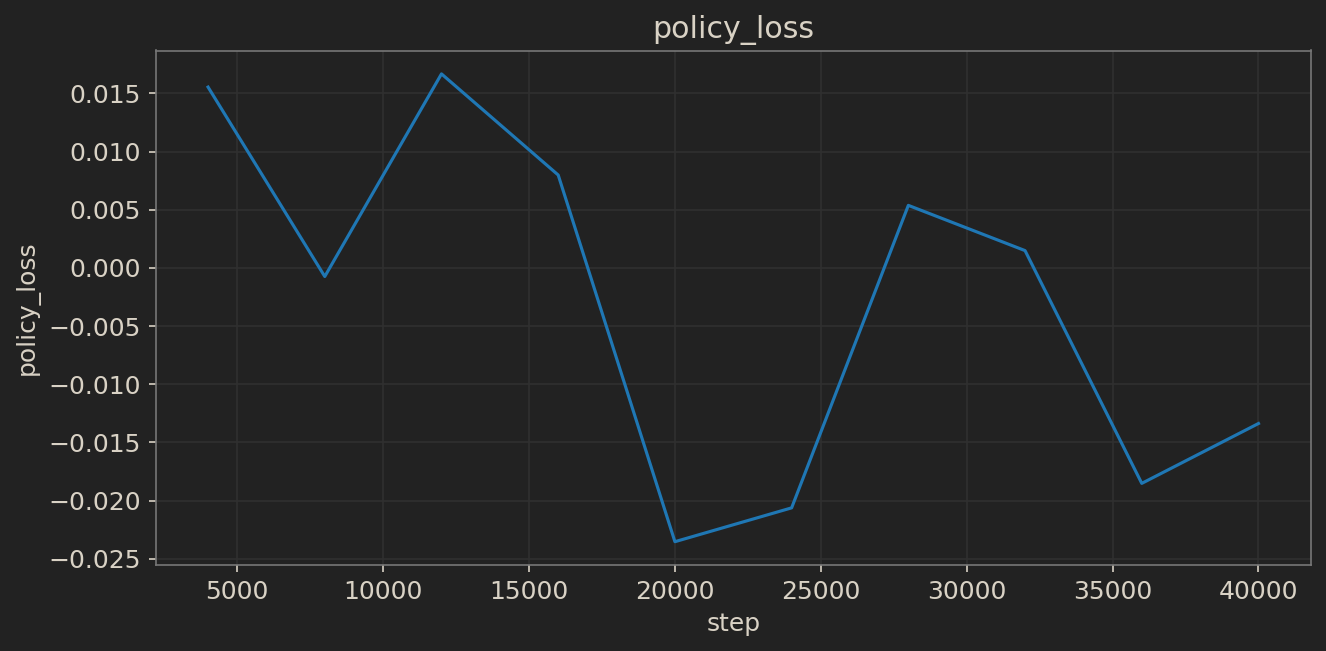

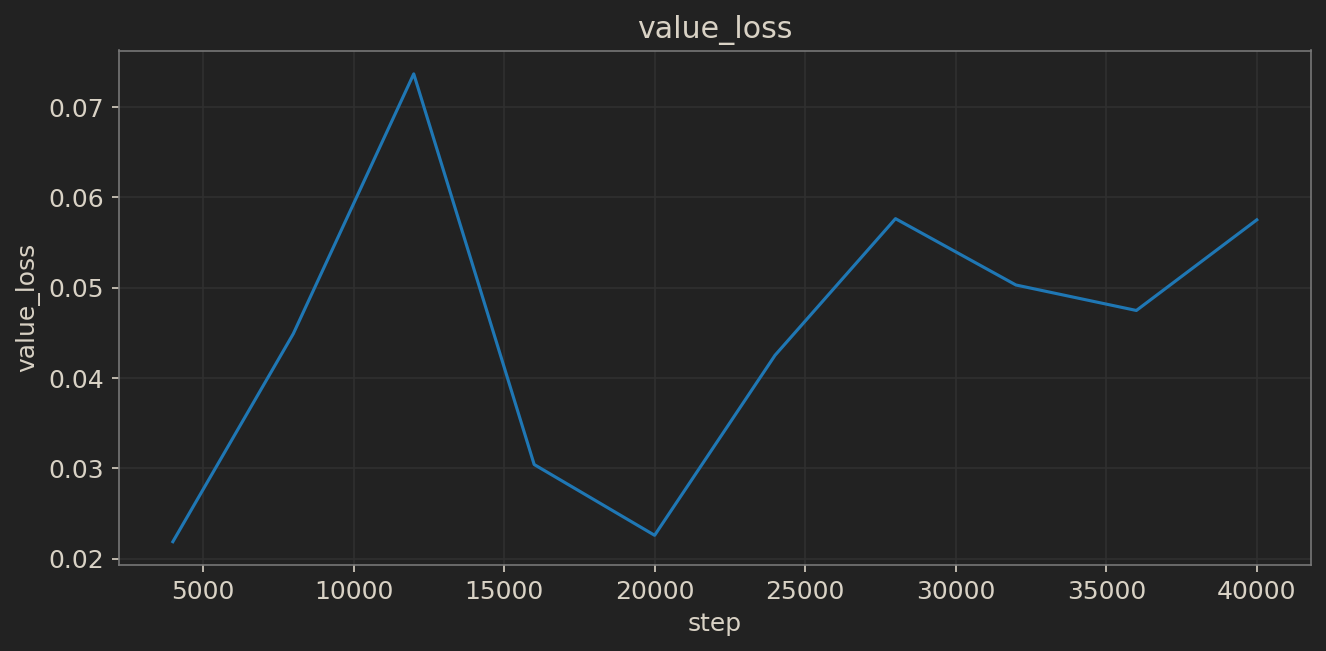

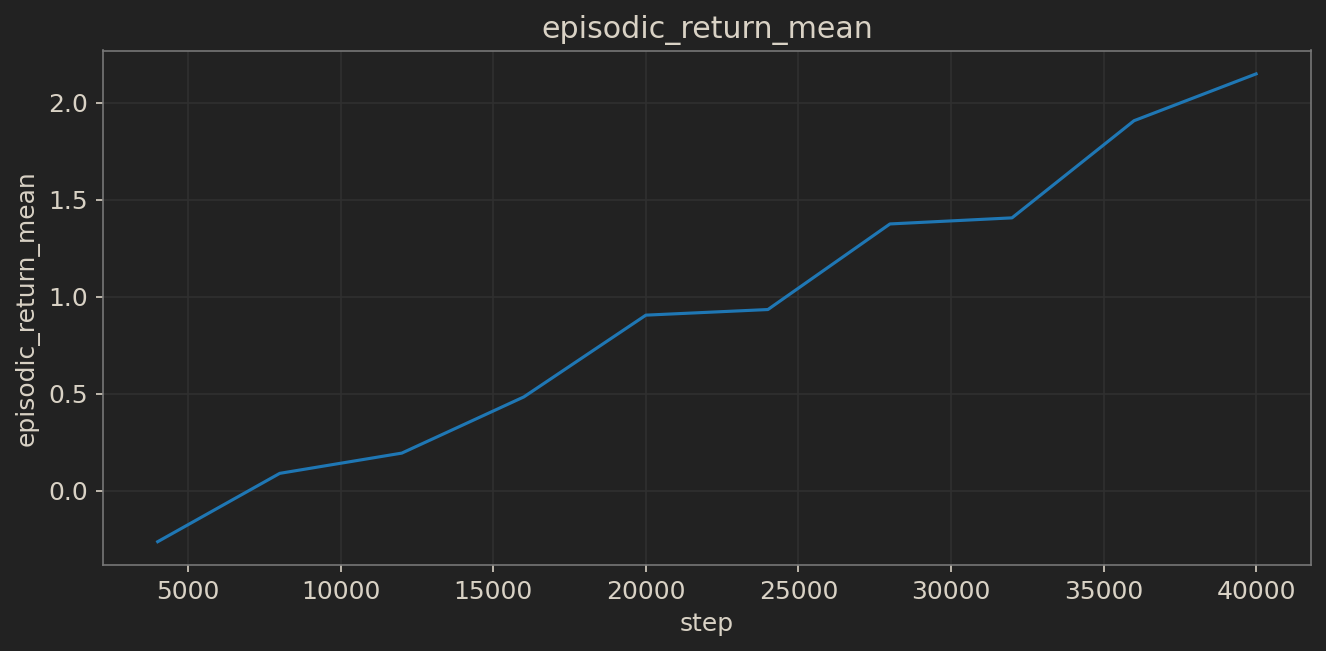

{'x_col': 'step',
 'plotted': ['policy_loss', 'value_loss', 'episodic_return_mean'],
 'saved': ['C:\\Users\\ordevoir\\Documents\\GitHub\\AgentsLab\\runs\\PPO_navigation_20250901_013259\\figures\\policy_loss.png',
  'C:\\Users\\ordevoir\\Documents\\GitHub\\AgentsLab\\runs\\PPO_navigation_20250901_013259\\figures\\value_loss.png',
  'C:\\Users\\ordevoir\\Documents\\GitHub\\AgentsLab\\runs\\PPO_navigation_20250901_013259\\figures\\episodic_return_mean.png']}

In [174]:
from agentslab.utils.plotters import plot_metrics_from_csv

plot_metrics_from_csv(
    pathCfg.csv_train,
    style="ordevoir-dark",          # опционально; если стиля нет — просто предупредит
    x_candidates=("step","return_mean","value_loss","epoch"),
    include=("step","policy_loss","value_loss","episodic_return_mean"),                   # можно передать список regex для фильтра
    exclude=None,                   # или исключить по regex
    ema=None,                       # например, ema=0.1 для сглаживания кривых
    downsample=None,                # например, downsample=10 для больших CSV
    save_dir=pathCfg.fig_dirs,                  # например, "figs" чтобы сохранять PNG
    show=True,                      # False — не показывать, только сохранять
    dpi=120,                        # DPI для сохранений
)

# Load 

In [175]:
chkptr.load("last", strict=False, map_location=genCfg.device)
collector.update_policy_weights_()  # чтобы коллектор увидел загруженные веса

# Evaluating

In [176]:
from agentslab.runners.evals import eval_policy_marl
from dataclasses import replace

max_steps = 100
eval_env = make_vmas_env(replace(envCfg, max_steps=max_steps))

eval_policy_marl(
    env=eval_env,               # можно использовать make_vmas_env(copied cfg) с num_envs=1
    policy=actor,               # твой actor / policy
    steps=max_steps,            # или None — возьмётся автоматически
    episodes=3,
    deterministic=True,
    progress=True,
    desc="marl-eval"
)

marl-eval:   0%|          | 0/3 [00:00<?, ?it/s]

{'return_mean': 0.23015165328979492,
 'return_std': 0.021990202367305756,
 'return_min': 0.2055184245109558,
 'return_max': 0.2478042095899582,
 'return_sum': 0.6904549598693848,
 'max_episode_length': 100,
 'num_episodes': 3}

# Play Episode (Render)

## Make Env and Load

In [177]:
from dataclasses import replace

max_steps = 300
env = make_vmas_env(replace(envCfg, max_steps=max_steps))

In [178]:
statefuls_play = {
    "policy": actor,   # свежий инстанс сети под загрузку весов
    # если нужно — добавь optimizer/scheduler, либо опускай их на плейбэке
}
chkptr_play = CheckpointManager(
    ckpt_dir=pathCfg.ckpt_dir,
    statefuls=statefuls_play,
)
chkptr_play.load("last", strict=False, map_location="cpu") 

C:\Users\ordevoir\Documents\GitHub\AgentsLab\src\agentslab\utils\checkpointers.py:239: UserWarning: В чекпоинте нет состояния для 'policy' — пропускаю.
  warnings.warn(f"В чекпоинте нет состояния для '{name}' — пропускаю.")


## Play

Состояние рендеринга сброшено. Можно запускать заново.
Environment сброшен
Запуск rollout с визуализацией:
- Максимальное количество шагов: 300
- FPS: 64
- Размер фигуры: (8, 6)


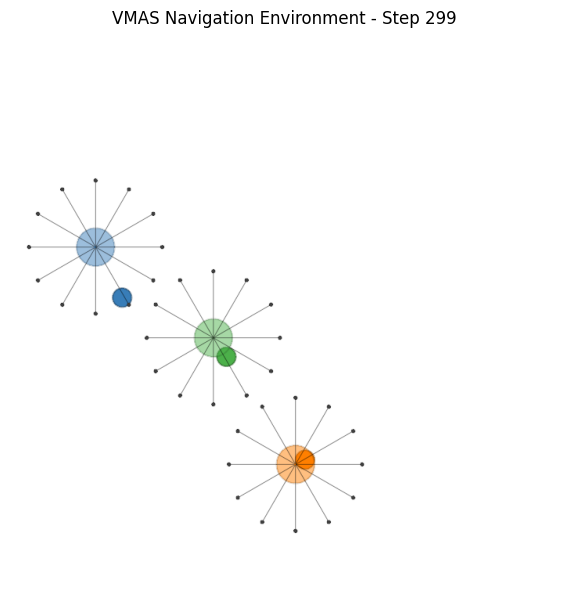


Rollout завершен!
Форма данных rollout: torch.Size([10, 300])
Время выполнения: 58.60 секунд
Реальный FPS: 5.1


In [179]:
from agentslab.envs.marl_envs import play_vmas

rollout_data = play_vmas(
    env=env,
    policy=actor,
    max_steps=max_steps,
    fps=64,  # 24 кадра в секунду
    # figsize=(10, 5),
    # verbose=True
)